# Lunar Lander with Q Learning

In this notebook we are going to train an agent to play the Lunar Lander game using tabular methods as:
- Q Learning
- Q Learning with Eligibility Traces
- Q Learning with Eligibility Traces and spatial decay

In [146]:
# General libraries
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# Deep learning
import torch
from torch import nn

# Video display
from IPython.display import Video
from moviepy import *

# Custom modules
from src.utils import *


# Set seed
SEED = 31
np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"Using seed {SEED}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

Using seed 31
Using device cuda


## The Environment

The Lunar Lander environment is a 2D environment where the agent has to land a spaceship on a landing pad.
The agent has 4 actions available:
- Do nothing
- Fire left orientation engine
- Fire main engine
- Fire right orientation engine

The agent receives a reward of 100 for landing on the landing pad and -100 for crashing. The agent also receives a reward proportional to the fuel used to land the spaceship.

The state space is a 8-dimensional vector with the following components:
- x position
- y position
- x velocity
- y velocity
- angle
- angular velocity
- left leg contact
- right leg contact

The environment is considered solved when the agent reaches an average reward of 200 over 100 episodes.

![Lunar Lander](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [147]:
import gymnasium as gym

env_name = 'LunarLander-v3'
env = gym.make(env_name)

In [148]:
from src.networks import ActorNet, CriticNet

n_episodes = 2_000

initial_lr_actor = 1e-3 * 1.2
final_lr_actor = 1e-3 * 1.2

initial_lr_critic = 5e-3 * 1.2
final_lr_critic = 5e-4 * 1.2
# gamma_actor = np.log(final_lr_actor / initial_lr_actor) / n_episodes
# gamma_critic = np.log(final_lr_critic / initial_lr_critic) / n_episodes
gamma_actor = 1
gamma_critic = 1

actor_net_main = ActorNet(
    input_dim=8,
    output_dim=4,
    hidden_dim=[64,64],
    batchnorm=False,
    activation=nn.ReLU,
    dropout=0.2,
    device=device,
    lr_scheduler_params={
        'gamma': gamma_actor
    },
    optimizer_params={
        "lr": initial_lr_actor,
        "weight_decay": 1e-8,
        "betas": (0.9, 0.99),
    },
    output_activation=nn.Softmax
)

critic_net_main = CriticNet(
    input_dim=8,
    hidden_dim=[64,64],
    output_dim=1,
    batchnorm=False,
    activation=nn.ReLU,
    dropout=0.1,
    device=device,
    lr_scheduler_params={
        'gamma': gamma_critic
    },
    optimizer_params={
        "lr": initial_lr_critic,
        "weight_decay": 1e-8,
        "betas": (0.9, 0.99),
    },
)

In [149]:
from src.DeepAgents import MonteCarloActorCritic as MCAC

agent = MCAC(
    env = env,
    discount_factor = 0.99,
    policy_net=actor_net_main,
    value_net=critic_net_main,
    inertia=0.0
)

In [150]:
rewards, losses_actor, losses_critic = agent.learn(n_episodes, 2_000)

rewards = pd.Series(rewards)
losses_actor = pd.Series(losses_actor)
losses_critic = pd.Series(losses_critic)

Simulating:   0%|          | 0/2000 [00:00<?, ?it/s]

Plot the rewards obtained by the agent during training

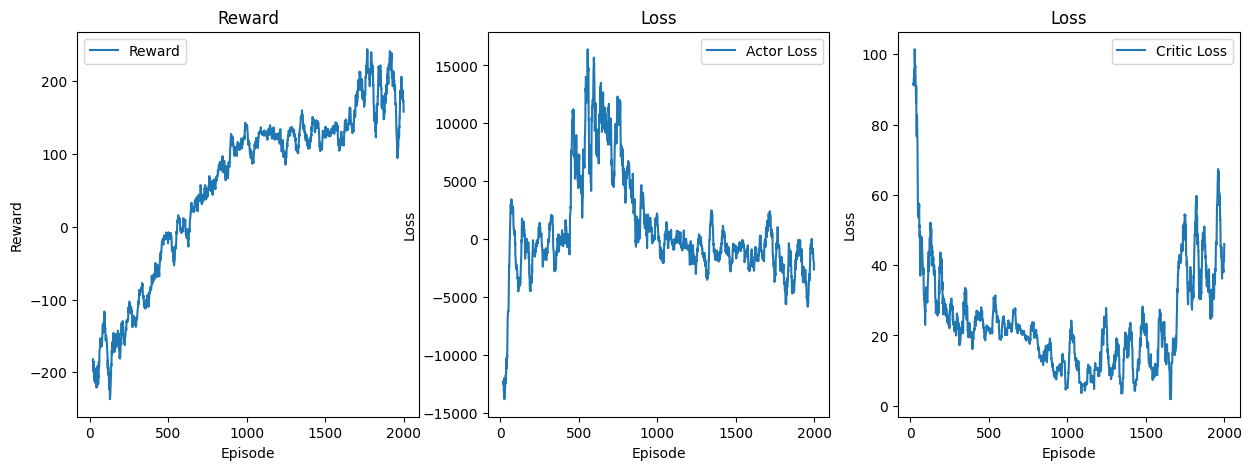

In [151]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(rewards.rolling(20).mean(), label="Reward")
ax[0].set_title("Reward")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Reward")
ax[0].legend()

ax[1].plot(losses_actor.rolling(20).mean(), label="Actor Loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Loss")
ax[1].legend()

ax[2].plot(losses_critic.rolling(20).mean(), label="Critic Loss")
ax[2].set_title("Loss")
ax[2].set_xlabel("Episode")
ax[2].set_ylabel("Loss")
ax[2].legend()

plt.show()

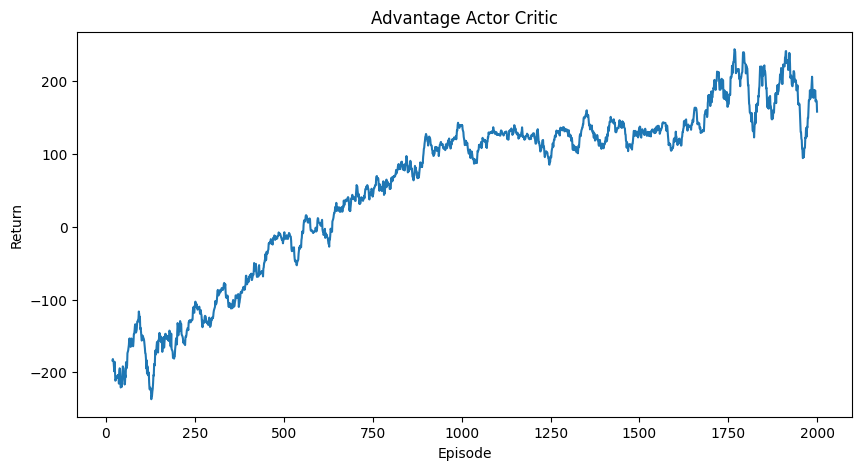

In [152]:
# Rewards plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(rewards.rolling(20).mean(), label="Returns")
ax.set_title("Advantage Actor Critic")
ax.set_xlabel("Episode")
ax.set_ylabel("Return")
plt.show()

## Test

In [153]:
def policy(state):
    action = agent.policy_net_target(torch.tensor(state, dtype=torch.float32).to(device))
    return action.argmax().item()

In [154]:
returns, trajectories, steps = test(
    env = env,
    policy = policy,
    n_episodes=1_000,
    horizon=3_000,
)

Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

In [155]:
np.mean(returns), np.std(returns)

(177.27430434968718, 130.11561103337166)

In [156]:
pickle.dump(trajectories, open(f"results/aac/trajectories.pkl", "wb"))
pickle.dump(returns, open(f"results/aac/returns.pkl", "wb"))
pickle.dump(steps, open(f"results/aac/steps.pkl", "wb"))

In [131]:
# First we divide the space into a grid of size 10x10
a, b = -2.5, 2.5
n = 128
grid = np.linspace(a*(n-1)/n, b*(n-1)/n, n)
X, Y = np.meshgrid(grid, grid)
Z = np.zeros_like(X)

# Then we evaluate the value function at each point of the grid
for cell in tqdm(zip(X.flatten(), Y.flatten())):
    # Fix the first two dimensions
    state = ([cell[0], cell[1], 0, 0, 0, 0, 0, 0])
    # sample random from uniform distribution of dim 6
    actions = []
    for _ in range(100):
        # Random uniform from the domain (-10, 10)^2 x (-2pi, 2pi) x (-10, 10) x {0,1}^2
        state[2] = np.random.uniform(-10, 10)
        state[2] = np.random.uniform(-10, 10)
        state[2] = np.random.uniform(-2*np.pi, 2*np.pi)
        state[2] = np.random.uniform(-10, 10)
        state[2] = np.random.choice([0,1])
        state[2] = np.random.choice([0,1])
        # Get the value of each action in that state
        action = policy(state)
        actions.append(action)
    most_common_action = max(set(actions), key=actions.count)
    Z_idx_x = np.where(grid == cell[0])[0][0]
    Z_idx_y = np.where(grid == cell[1])[0][0]
    
    Z[Z_idx_x, Z_idx_y] = most_common_action

0it [00:00, ?it/s]

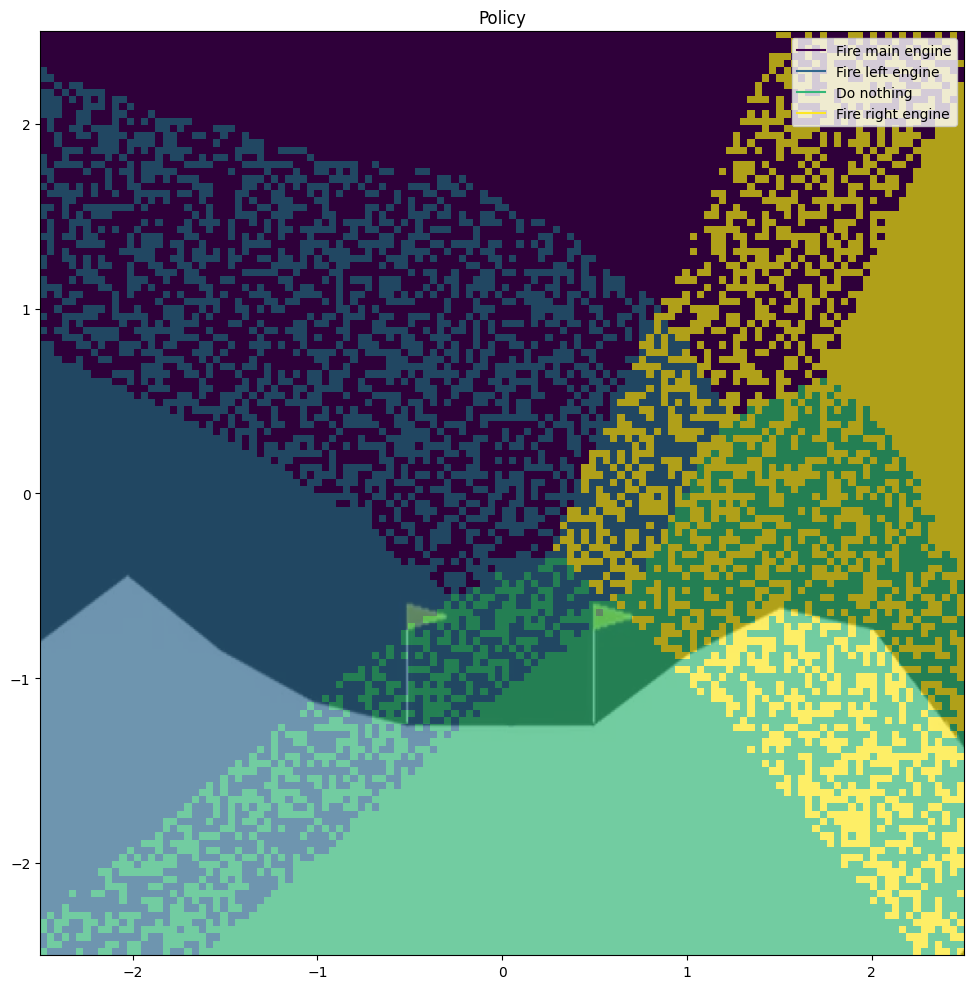

In [145]:
# Suppose Z is your 2D data, and (a, b) define the boundaries 
# for both x and y coordinates in 'extent'.
plt.figure(figsize=(10, 10))

# Load your PNG image
img = plt.imread('LunarLander Env.png')

# Overlay the PNG image on top of the heatmap
# Use the same extent if you want it to align exactly with the heatmap
# Adjust alpha to control transparency
img = np.flipud(img)
plt.imshow(img, extent=(a, b, a, b), origin='lower', zorder=1)

# Display the heatmap
plt.imshow(np.rot90(np.rot90(np.rot90(Z))), extent=(a, b, a, b), origin='lower', zorder=2, cmap='viridis', alpha=0.7)
plt.title("Policy")
# Get colors of colormap
colors = plt.cm.viridis(np.linspace(0, 1, 4))
actions = ['Fire main engine','Fire left engine', 'Do nothing', 'Fire right engine']

# Add legend for the four different actions
for i in range(4):
    plt.plot([], [], color=colors[i], label=actions[i])
plt.legend()

# Save as png of high quality
plt.savefig("results/aac/policy.png", dpi=300)

plt.tight_layout()
plt.show()

KeyError: (-2.5, -2.5)

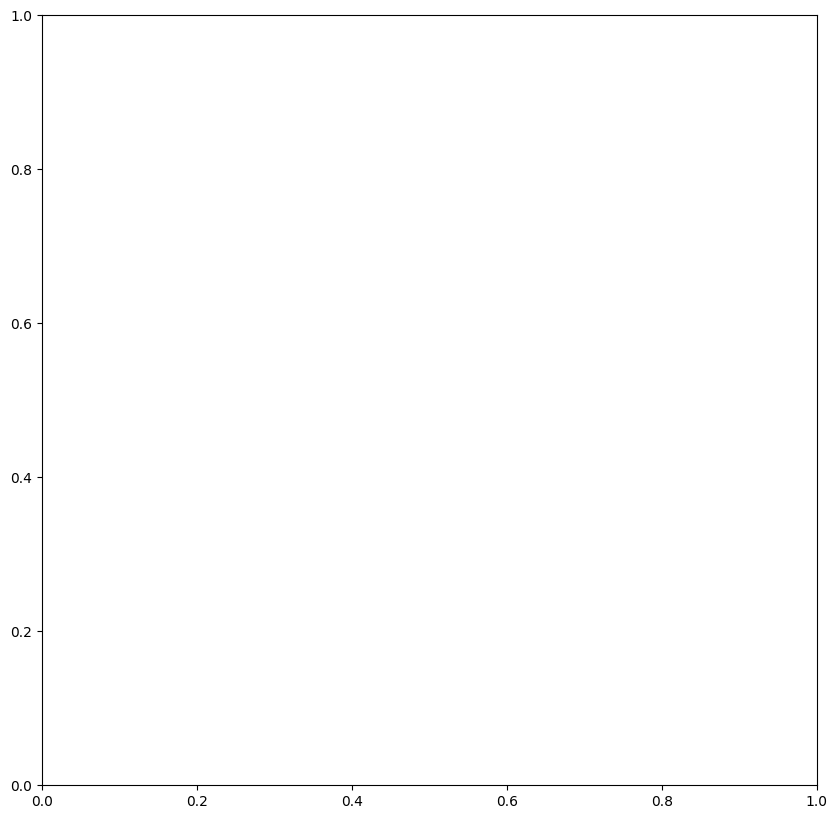

In [43]:
# heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.linspace(a, b, n)
y = np.linspace(a, b, n)
X, Y = np.meshgrid(x, y)
Z = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        Z[i, j] = action_map[(X[i, j], Y[i, j])]
ax.pcolormesh(X, Y, Z, shading='auto')
plt.show()

## Policy interpretation

## Video

Generate video of the agent playing the game:

In [ ]:
video_dir = Path('./gym_videos')
video_dir.mkdir(parents=True, exist_ok=True)

env = gym.make(env_name, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_dir,
    name_prefix=env_name,
)

In [ ]:
frames, rewards = play(agent, env, 1)

In [ ]:
for i, episode_frames in enumerate(frames):
    filename = f"{video_dir}/{env_name}_{i}.mp4"
    clip = ImageSequenceClip(episode_frames, fps=60)
    clip.write_videofile(filename, codec='libx264')
    
    print(f"Episode {i} reward: {rewards[i]:.2f}")    
    
env.close()

In [ ]:
videos = [ x for x in list(video_dir.glob('*.mp4')) if env_name in x.name]

for video in videos:
    print(video)
    display(Video(video))